In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, ResNet50, VGG16, DenseNet121
from sklearn.metrics import classification_report, confusion_matrix

# Part I. Data Extraction

In [2]:
# Data
train_dir = r"E:\fruits\train"
test_dir = r"E:\fruits\test"

In [3]:
# Parameters
IMAGE_SIZE = (320, 320)
BATCH_SIZE = 32
NUM_CLASSES = 16
EPOCHS = 10

In [4]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.3,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1281 images belonging to 16 classes.
Found 319 images belonging to 16 classes.
Found 320 images belonging to 16 classes.


# Part II. Exploratory Data Analysis

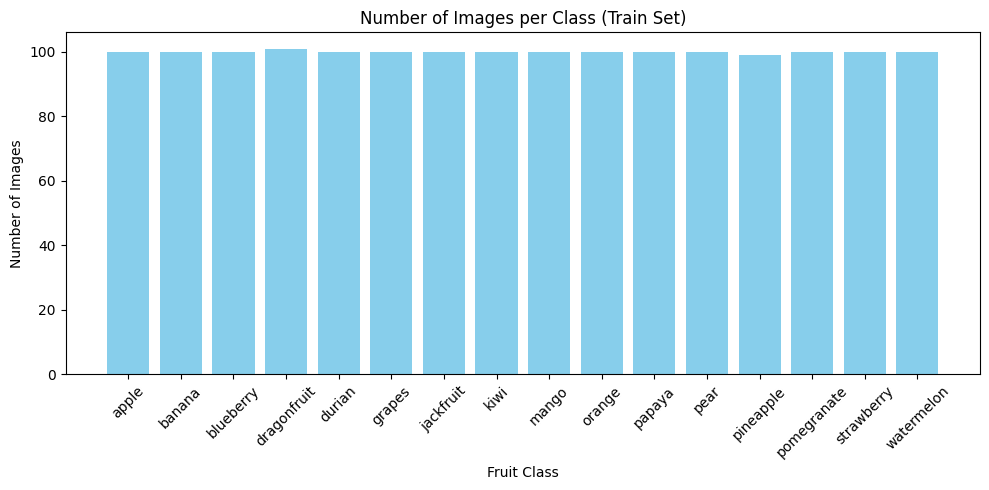

In [5]:
def count_images_per_class(path):
    class_counts = {}
    for class_name in os.listdir(path):
        class_folder = os.path.join(path, class_name)
        if os.path.isdir(class_folder):
            count = len([
                file for file in os.listdir(class_folder)
                if os.path.isfile(os.path.join(class_folder, file))
            ])
            class_counts[class_name] = count
    return class_counts

# Count for training set
train_counts = count_images_per_class(train_dir)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values(), color='skyblue')
plt.title("Number of Images per Class (Train Set)")
plt.xlabel("Fruit Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

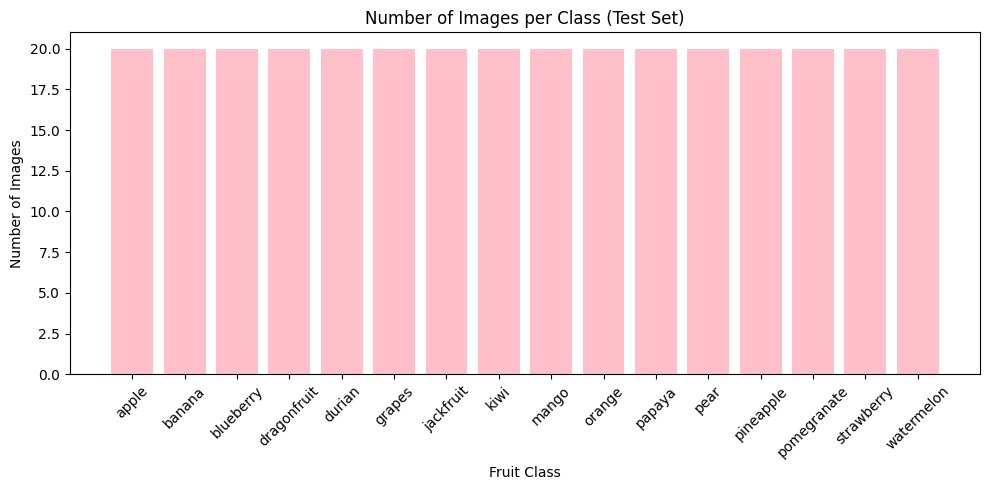

In [6]:
# Count for testing set
test_counts = count_images_per_class(test_dir)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(test_counts.keys(), test_counts.values(), color='pink')
plt.title("Number of Images per Class (Test Set)")
plt.xlabel("Fruit Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

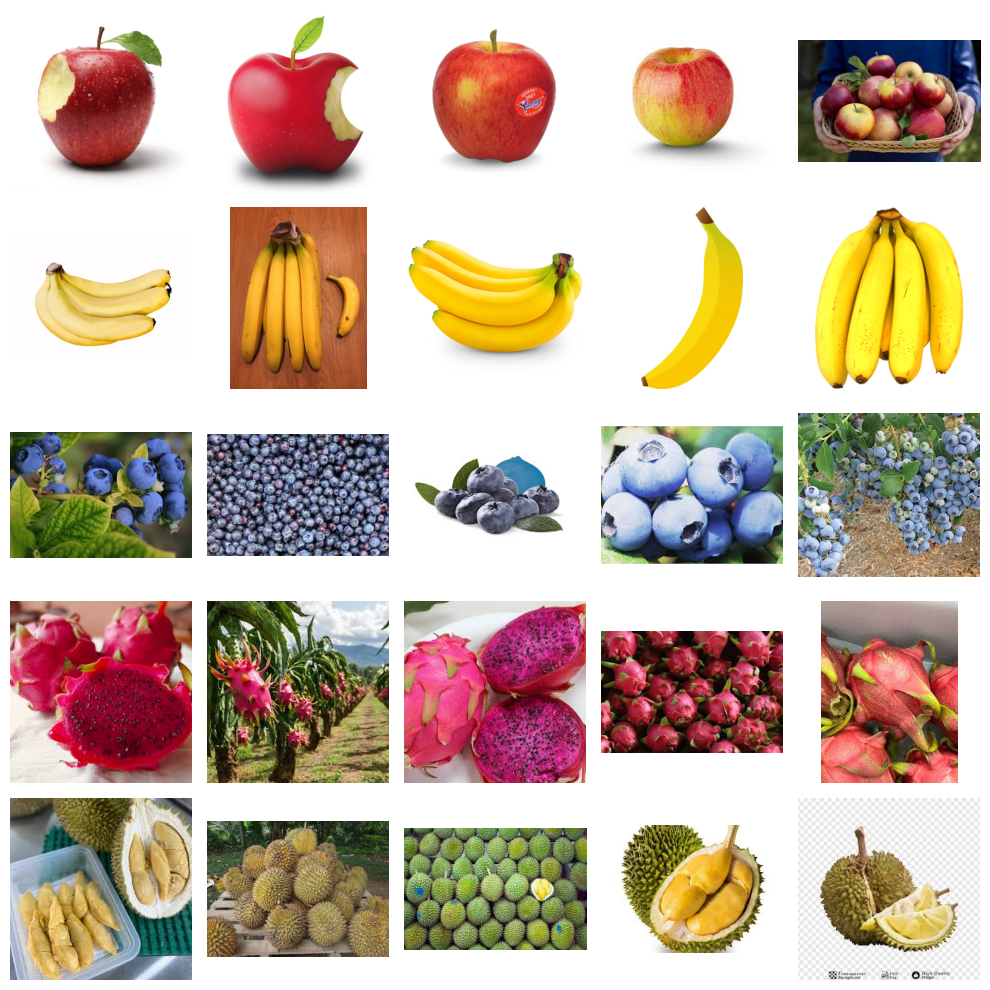

In [7]:
def show_random_images(path, classes=None, num_classes=5, images_per_class=5):
    if classes is None:
        classes = os.listdir(path)
    classes = classes[:num_classes]
    
    plt.figure(figsize=(images_per_class * 2, num_classes * 2))

    for i, fruit_class in enumerate(classes):
        fruit_folder = os.path.join(path, fruit_class)
        images = os.listdir(fruit_folder)
        random.shuffle(images)
        selected = images[:images_per_class]

        for j, image_name in enumerate(selected):
            img_path = os.path.join(fruit_folder, image_name)
            img = mpimg.imread(img_path)
            plt.subplot(num_classes, images_per_class, i * images_per_class + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(fruit_class, size=12)

    plt.tight_layout()
    plt.show()

# Show random images from 5 classes, 5 images each
show_random_images(train_dir, num_classes=5, images_per_class=5)

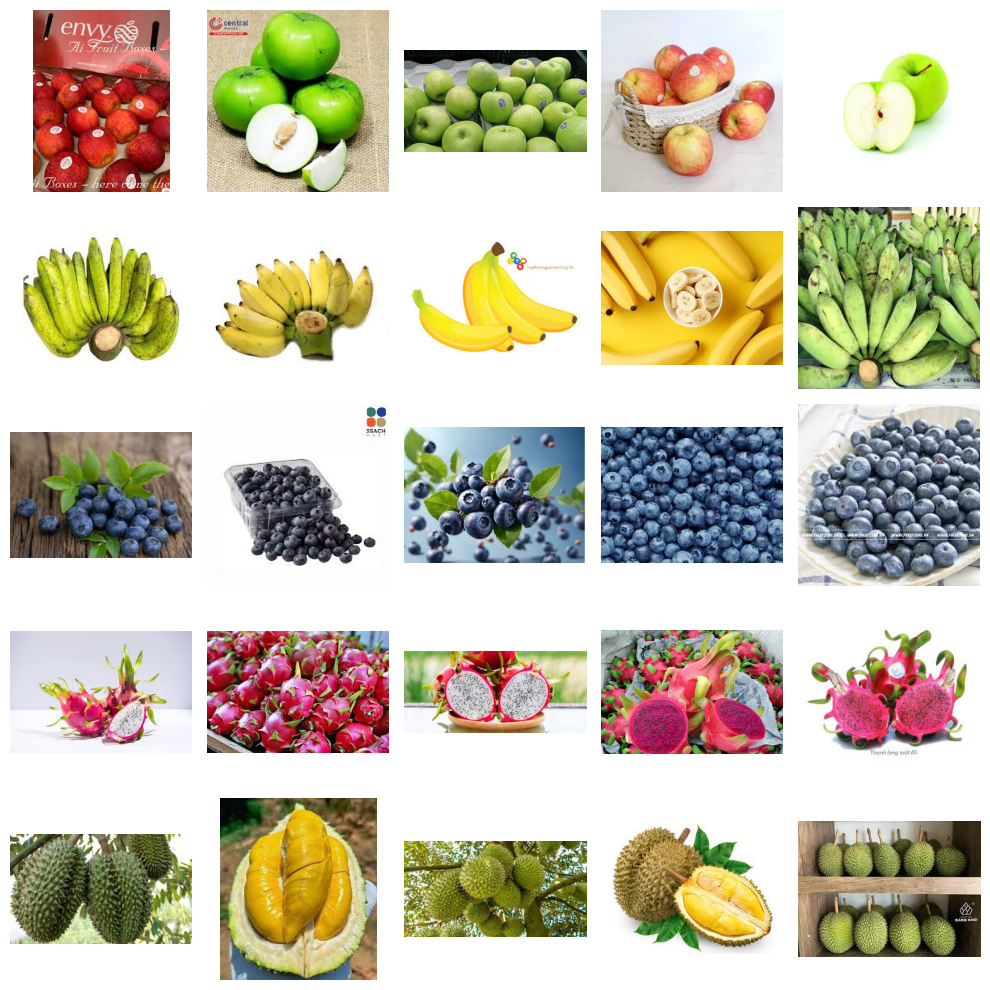

In [8]:
# Show random images from 5 classes, 5 images each
show_random_images(test_dir, num_classes=5, images_per_class=5)

# Part III. Building Models

## MobileNetV2

In [9]:
# Build Model
mobilenet_base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(320, 320, 3))
mobilenet_base_model.trainable = False

x = GlobalAveragePooling2D()(mobilenet_base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

mobilenet_model = Model(inputs=mobilenet_base_model.input, outputs=output)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.2, verbose=1)
]

mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_2880\1311248654.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(320, 320, 3))
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
34/41 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.1920 - loss: 2.7172

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.3544 - loss: 2.2857 - val_accuracy: 0.7962 - val_loss: 1.4026 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.6807 - loss: 1.4660 - val_accuracy: 0.8715 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 153s 4s/step - accuracy: 0.7627 - loss: 1.2309 - val_accuracy: 0.8715 - val_loss: 0.9679 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.8009 - loss: 1.1434 - val_accuracy: 0.8871 - val_loss: 0.9397 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.8392 - loss: 1.0898 - val_accuracy: 0.8966 - val_loss: 0.9068 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.8423 - loss: 1.0715 - val_accuracy: 0.8777 - val_loss: 0.9660 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.8595 - loss: 1.0391 - val_accuracy: 0.90

In [10]:
# Evaluate Model
loss, accuracy = mobilenet_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8656 - loss: 1.0019
Test Accuracy: 86.56%


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
              precision    recall  f1-score   support

       apple       0.90      0.95      0.93        20
      banana       0.94      0.80      0.86        20
   blueberry       0.70      0.95      0.81        20
 dragonfruit       0.95      1.00      0.98        20
      durian       0.94      0.85      0.89        20
      grapes       0.93      0.70      0.80        20
   jackfruit       0.87      1.00      0.93        20
        kiwi       0.95      0.95      0.95        20
       mango       0.77      0.85      0.81        20
      orange       1.00      0.95      0.97        20
      papaya       0.57      1.00      0.73        20
        pear       1.00      0.80      0.89        20
   pineapple       0.94      0.80      0.86        20
 pomegranate       0.93      0.65      0.76        20
  strawberry       0.86      0.95      0.90        20
  watermelon       1.00      0.65      0.79        20

    accuracy                           0.

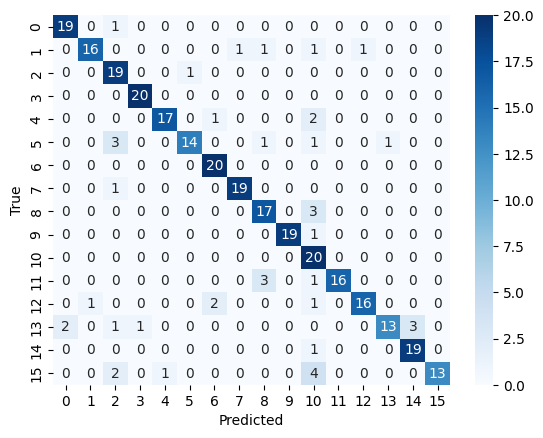

In [11]:
# Predict on test set
mobilenet_y_true = test_data.classes
mobilenet_y_pred = mobilenet_model.predict(test_data)
mobilenet_y_pred_labels = np.argmax(mobilenet_y_pred, axis=1)

# Confusion matrix
mobilenet_cm = confusion_matrix(mobilenet_y_true, mobilenet_y_pred_labels)
sns.heatmap(mobilenet_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

# Classification report
print(classification_report(mobilenet_y_true, mobilenet_y_pred_labels, target_names=test_data.class_indices.keys()))

## ResNet50

In [13]:
# Build Model
resnet_base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(320, 320, 3)
)
resnet_base_model.trainable = False

x = GlobalAveragePooling2D()(resnet_base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

resnet_model = Model(inputs=resnet_base_model.input, outputs=output)

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.2, verbose=1)
]

# Train model
resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
16/41 ━━━━━━━━━━━━━━━━━━━━ 2:18 6s/step - accuracy: 0.0601 - loss: 3.7253

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 7594s 190s/step - accuracy: 0.0648 - loss: 2.9860 - val_accuracy: 0.0627 - val_loss: 2.7723 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 290s 7s/step - accuracy: 0.0679 - loss: 2.7734 - val_accuracy: 0.0721 - val_loss: 2.7718 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 264s 6s/step - accuracy: 0.0710 - loss: 2.7710 - val_accuracy: 0.0909 - val_loss: 2.7677 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 257s 6s/step - accuracy: 0.0757 - loss: 2.7678 - val_accuracy: 0.0752 - val_loss: 2.7713 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - accuracy: 0.0640 - loss: 2.7730 - val_accuracy: 0.0627 - val_loss: 2.7721 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 262s 6s/step - accuracy: 0.0765 - loss: 2.7683 - val_accuracy: 0.0972 - val_loss: 2.7548 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 243s 6s/step - accuracy: 0.0781 - loss: 2.7632 - val_accuracy: 0

In [14]:
# Evaluate Model
loss, accuracy = resnet_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.0594 - loss: 2.7363
Test Accuracy: 5.94%


10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step


C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

       apple       0.00      0.00      0.00        20
      banana       0.00      0.00      0.00        20
   blueberry       0.11      0.80      0.20        20
 dragonfruit       0.02      0.15      0.03        20
      durian       0.00      0.00      0.00        20
      grapes       0.00      0.00      0.00        20
   jackfruit       0.00      0.00      0.00        20
        kiwi       0.00      0.00      0.00        20
       mango       0.00      0.00      0.00        20
      orange       0.00      0.00      0.00        20
      papaya       0.00      0.00      0.00        20
        pear       0.00      0.00      0.00        20
   pineapple       0.00      0.00      0.00        20
 pomegranate       0.00      0.00      0.00        20
  strawberry       0.00      0.00      0.00        20
  watermelon       0.00      0.00      0.00        20

    accuracy                           0.06       320
   macro avg       0.01   

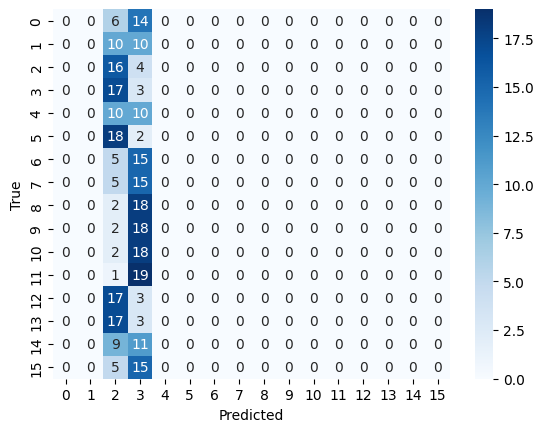

In [15]:
# Predict on test set
resnet_y_true = test_data.classes
resnet_y_pred = resnet_model.predict(test_data)
resnet_y_pred_labels = np.argmax(resnet_y_pred, axis=1)

# Confusion matrix
resnet_cm = confusion_matrix(resnet_y_true, resnet_y_pred_labels)
sns.heatmap(resnet_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

# Classification report
print(classification_report(resnet_y_true, resnet_y_pred_labels, target_names=test_data.class_indices.keys()))

## VGG16

In [16]:
# Build Model
vgg_base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(320, 320, 3)
)
vgg_base_model.trainable = False

x = GlobalAveragePooling2D()(vgg_base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

vgg_model = Model(inputs=vgg_base_model.input, outputs=output)

vgg_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.2, verbose=1)
]

vgg_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
30/41 ━━━━━━━━━━━━━━━━━━━━ 2:28 13s/step - accuracy: 0.0672 - loss: 2.8986

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 713s 17s/step - accuracy: 0.0859 - loss: 2.7864 - val_accuracy: 0.2194 - val_loss: 2.6004 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 711s 17s/step - accuracy: 0.1944 - loss: 2.5717 - val_accuracy: 0.3511 - val_loss: 2.4484 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 712s 17s/step - accuracy: 0.2498 - loss: 2.4586 - val_accuracy: 0.4796 - val_loss: 2.3000 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 707s 17s/step - accuracy: 0.3482 - loss: 2.3214 - val_accuracy: 0.5674 - val_loss: 2.1583 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 709s 17s/step - accuracy: 0.3810 - loss: 2.2166 - val_accuracy: 0.5831 - val_loss: 2.0751 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 710s 17s/step - accuracy: 0.3927 - loss: 2.1528 - val_accuracy: 0.5361 - val_loss: 2.0213 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 712s 17s/step - accuracy: 0.4387 - loss: 2.0757 - val_accurac

In [17]:
# Evaluate Model
loss, accuracy = vgg_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step - accuracy: 0.5750 - loss: 1.7830
Test Accuracy: 57.50%


10/10 ━━━━━━━━━━━━━━━━━━━━ 141s 14s/step
              precision    recall  f1-score   support

       apple       0.00      0.00      0.00        20
      banana       0.82      0.45      0.58        20
   blueberry       0.55      0.80      0.65        20
 dragonfruit       0.81      0.85      0.83        20
      durian       0.76      0.80      0.78        20
      grapes       0.65      0.85      0.74        20
   jackfruit       0.36      0.40      0.38        20
        kiwi       0.46      0.85      0.60        20
       mango       0.31      0.50      0.38        20
      orange       0.77      0.50      0.61        20
      papaya       0.00      0.00      0.00        20
        pear       0.59      0.65      0.62        20
   pineapple       1.00      0.65      0.79        20
 pomegranate       0.73      0.80      0.76        20
  strawberry       0.79      0.55      0.65        20
  watermelon       0.34      0.55      0.42        20

    accuracy                           

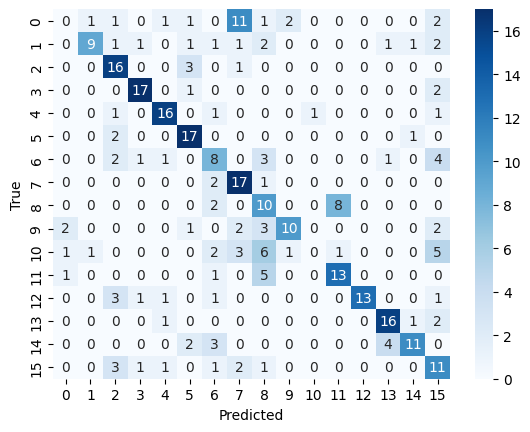

In [18]:
# Predict on test set
vgg_y_true = test_data.classes
vgg_y_pred = vgg_model.predict(test_data)
vgg_y_pred_labels = np.argmax(vgg_y_pred, axis=1)

# Confusion matrix
vgg_cm = confusion_matrix(vgg_y_true, vgg_y_pred_labels)
sns.heatmap(vgg_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

# Classification report
print(classification_report(vgg_y_true, vgg_y_pred_labels, target_names=test_data.class_indices.keys()))

## DenseNet121

In [19]:
# Build Model
densenet_base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(320, 320, 3)
)
densenet_base_model.trainable = False

x = GlobalAveragePooling2D()(densenet_base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

densenet_model = Model(inputs=densenet_base_model.input, outputs=output)

densenet_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.2, verbose=1)
]

densenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
 4/41 ━━━━━━━━━━━━━━━━━━━━ 3:05 5s/step - accuracy: 0.0781 - loss: 3.2680

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accuracy: 0.2287 - loss: 2.5543 - val_accuracy: 0.6771 - val_loss: 1.8700 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - accuracy: 0.4863 - loss: 1.8755 - val_accuracy: 0.8715 - val_loss: 1.3189 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.6729 - loss: 1.4940 - val_accuracy: 0.8966 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 266s 6s/step - accuracy: 0.7580 - loss: 1.2904 - val_accuracy: 0.8966 - val_loss: 0.9996 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 271s 7s/step - accuracy: 0.8072 - loss: 1.1715 - val_accuracy: 0.9279 - val_loss: 0.9242 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 248s 6s/step - accuracy: 0.7814 - loss: 1.2008 - val_accuracy: 0.9091 - val_loss: 0.9307 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 279s 7s/step - accuracy: 0.8197 - loss: 1.1510 - val_accuracy: 0.90

In [20]:
# Evaluate Model
loss, accuracy = densenet_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.9031 - loss: 0.9442
Test Accuracy: 90.31%


10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 5s/step
              precision    recall  f1-score   support

       apple       0.95      1.00      0.98        20
      banana       0.89      0.85      0.87        20
   blueberry       0.80      1.00      0.89        20
 dragonfruit       1.00      1.00      1.00        20
      durian       1.00      0.90      0.95        20
      grapes       1.00      0.75      0.86        20
   jackfruit       0.87      1.00      0.93        20
        kiwi       1.00      0.95      0.97        20
       mango       0.75      0.90      0.82        20
      orange       1.00      1.00      1.00        20
      papaya       0.62      0.90      0.73        20
        pear       0.94      0.85      0.89        20
   pineapple       1.00      0.85      0.92        20
 pomegranate       1.00      0.95      0.97        20
  strawberry       0.90      0.95      0.93        20
  watermelon       1.00      0.60      0.75        20

    accuracy                           0.

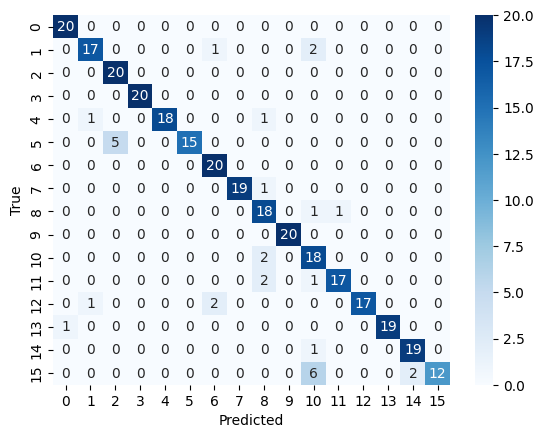

In [21]:
# Predict on test set
densenet_y_true = test_data.classes
densenet_y_pred = densenet_model.predict(test_data)
densenet_y_pred_labels = np.argmax(densenet_y_pred, axis=1)

# Confusion matrix
densenet_cm = confusion_matrix(densenet_y_true, densenet_y_pred_labels)
sns.heatmap(densenet_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

# Classification report
print(classification_report(densenet_y_true, densenet_y_pred_labels, target_names=test_data.class_indices.keys()))

DenseNet121 achieved the highest accuracy at 90.31%, followed by MobileNetV2 with an accuracy of 86.56%

# Part IV. Fine Tuning Model

## DenseNet121

In [10]:
for layer in densenet_base_model.layers[-30:]:
    layer.trainable = True

densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

fine_tune_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.2, verbose=1)
]

densenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=fine_tune_callbacks
)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 307s 7s/step - accuracy: 0.7775 - loss: 1.2204 - val_accuracy: 0.9216 - val_loss: 0.9154 - learning_rate: 1.0000e-05
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - accuracy: 0.7955 - loss: 1.1986 - val_accuracy: 0.9373 - val_loss: 0.8793 - learning_rate: 1.0000e-05
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 262s 6s/step - accuracy: 0.8212 - loss: 1.1451 - val_accuracy: 0.9279 - val_loss: 0.9016 - learning_rate: 1.0000e-05
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 272s 7s/step - accuracy: 0.8290 - loss: 1.1404 - val_accuracy: 0.9122 - val_loss: 0.9002 - learning_rate: 1.0000e-05
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 259s 6s/step - accuracy: 0.8345 - loss: 1.1187 - val_accuracy: 0.9248 - val_loss: 0.9023 - learning_rate: 1.0000e-05
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8036 - loss: 1.1509
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
41/41 ━━━━━━━━━━━━━━━━━━━━ 261s 6s/step - accuracy: 0.8454 - loss

In [11]:
# Evaluate Model
loss, accuracy = densenet_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.9312 - loss: 0.9098
Test Accuracy: 93.12%


10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step
              precision    recall  f1-score   support

       apple       0.95      0.95      0.95        20
      banana       0.95      0.90      0.92        20
   blueberry       0.87      1.00      0.93        20
 dragonfruit       1.00      1.00      1.00        20
      durian       0.90      0.95      0.93        20
      grapes       1.00      0.85      0.92        20
   jackfruit       0.83      0.95      0.88        20
        kiwi       1.00      0.95      0.97        20
       mango       0.86      0.95      0.90        20
      orange       1.00      1.00      1.00        20
      papaya       0.82      0.90      0.86        20
        pear       0.95      0.90      0.92        20
   pineapple       1.00      0.80      0.89        20
 pomegranate       0.95      0.95      0.95        20
  strawberry       0.95      1.00      0.98        20
  watermelon       0.94      0.85      0.89        20

    accuracy                           0.

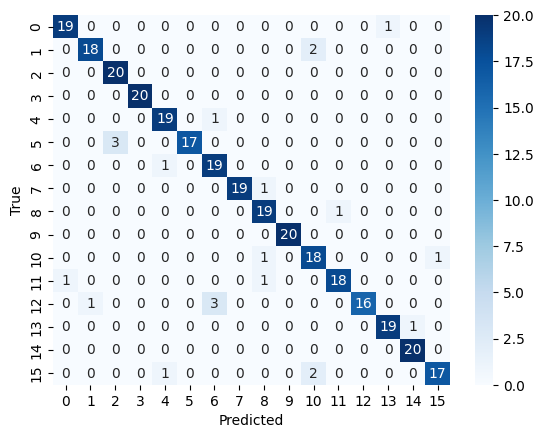

In [12]:
# Predict on test set
densenet_y_true = test_data.classes
densenet_y_pred = densenet_model.predict(test_data)
densenet_y_pred_labels = np.argmax(densenet_y_pred, axis=1)

# Confusion matrix
densenet_cm = confusion_matrix(densenet_y_true, densenet_y_pred_labels)
sns.heatmap(densenet_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

# Classification report
print(classification_report(densenet_y_true, densenet_y_pred_labels, target_names=test_data.class_indices.keys()))

## MobileNetV2

In [13]:
# Build Model
mobilenet_base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(320, 320, 3))
mobilenet_base_model.trainable = False

x = GlobalAveragePooling2D()(mobilenet_base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

mobilenet_model = Model(inputs=mobilenet_base_model.input, outputs=output)

C:\Users\Admin\AppData\Local\Temp\ipykernel_28536\2626826164.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(320, 320, 3))


In [14]:
for layer in mobilenet_base_model.layers[-30:]:
    layer.trainable = True

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

fine_tune_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=4, factor=0.2, verbose=1)
]

mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=fine_tune_callbacks
)

Epoch 1/20
13/41 ━━━━━━━━━━━━━━━━━━━━ 1:37 3s/step - accuracy: 0.0499 - loss: 3.2597

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.0671 - loss: 3.1353 - val_accuracy: 0.0909 - val_loss: 2.8158 - learning_rate: 1.0000e-05
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.1038 - loss: 2.8987 - val_accuracy: 0.1818 - val_loss: 2.6590 - learning_rate: 1.0000e-05
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.1491 - loss: 2.7158 - val_accuracy: 0.2382 - val_loss: 2.5534 - learning_rate: 1.0000e-05
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.1858 - loss: 2.6062 - val_accuracy: 0.2947 - val_loss: 2.4176 - learning_rate: 1.0000e-05
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.2436 - loss: 2.4454 - val_accuracy: 0.3668 - val_loss: 2.3169 - learning_rate: 1.0000e-05
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.3099 - loss: 2.3329 - val_accuracy: 0.4232 - val_loss: 2.1930 - learning_rate: 1.0000e-05
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.3614 - loss: 2.1

In [15]:
loss, accuracy = mobilenet_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7844 - loss: 1.2967
Test Accuracy: 78.44%
